<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nguwijy/deep_branching_with_domain/blob/master/notebooks/mc_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import numbers
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm 
import numpy as np
from scipy.stats import norm
from functools import partial
from branch.galerkin import DGMNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Introduction
In this notebook, we show how to obtain the Monte Carlo samples
without training the neural network using three examples.
Suppose we are interested in
evaluating the solution $u(t, x)$
at $t = 0$ and $x = (x_0, \ldots, x_{d-2}, x_{d-1}) = (0, \ldots, 0, X)$,
where $X$ are the uniform points between x_lo and x_hi.

Firstly, we generate the `tx` grid.
```python
tx = torch.zeros(nb_spatial, model.dim_in + 1, device=device)
tx[:, -1] = torch.linspace(model.x_lo, model.x_hi, nb_spatial)
```

Secondly, we use the function `gen_sample` available in `branch.branch` module
to generate samples.
If we do not specify the keyword `tx` when calling `gen_sample`,
the function will generate uniform random variable for `tx`
and evaluate the solution based on the uniformly generated `tx`.
However, if we pass the keyword `tx`,
the function will evaluate the solution based on the `tx` that we specified.
```python
x, y = model.gen_sample(patch=0, tx=tx)
```

Then, we can plot `y` together with the exact solution for comparison.
The steps are summarized in the `simulate_mc_and_plot` function below.

In [2]:
def simulate_mc_and_plot(model, nb_spatial=10, repeats=1):
    tx = torch.zeros(nb_spatial, model.dim_in + 1, device=device)
    tx[:, -1] = torch.linspace(model.x_lo, model.x_hi, nb_spatial)
    mc = 0
    for _ in range(repeats):
        x, y = model.gen_sample(patch=0, tx=tx)
        mc += y[:, 0].cpu()
    mc /= repeats
    
    # original grid for mc
    mc_grid = tx[:, -1].cpu()
    # finer grid for exact solution
    x = np.zeros((model.dim_in, 10 * nb_spatial))
    exact_grid = np.linspace(model.x_lo, model.x_hi, 10 * nb_spatial)
    x[-1] = exact_grid
    exact = exact_example(t=0, x=x, T=T, coordinate=0)
    terminal = exact_example(t=T, x=x, T=T, coordinate=0)

    # plot
    plt.scatter(mc_grid, mc, s=50, facecolors='none', edgecolors='black', label='MC')
    plt.plot(exact_grid, exact, color='black', label='exact')
    plt.plot(exact_grid, terminal, '--',color='black', label='terminal')
    plt.legend()
    plt.show()

## Example 3: time-dependent Poiseuille flow
We consider the 2D Navier-Stokes equation inside the square $[-L, L]^2$. For this, we let the wall be the horizontal lines $y = L$ and $y = L$, and let the inlet at $x = -L$ flowing to the direction $x = L$.

It can be checked that the velocity flow $u(t, x, y) = (g(t, y), 0)$ with the pressure $p(t, x, y) = \alpha v_0^2 - \frac{\nu v_0}{L^2} x$ satisfies the Navier-Stokes equation
$$
\partial_t u(t,x) + \frac{\nu}{2} \Delta u(t,x) =\nabla p(t,x) + ( u \cdot \nabla ) u,
$$
with the divergence free condition ${\rm div \ \! } u = 0$,
where
$$
g(t, y) = v_0 \left( 1 - \frac{y^2}{L^2} \right) + \sum\limits_{n=0}^\infty \frac{(-1)^{n+1} 32 v_0}{\pi^3(2n+1)^3} \cos \frac{(2n+1)\pi y}{2L} \exp\left(- \frac{(2n+1)^2 \pi^2 \nu (T-t)}{8L^2}\right).
$$
We try to reproduce Fig 2 in [this article](https://www.researchgate.net/publication/222552962_SPH_simulations_of_time-dependent_Poiseuille_flow_at_low_Reynolds_numbers).

In [3]:
# the formula given by Borodin, see compare_boundary_method.ipynb fore more information
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-10,
    upper_bound=10,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=-10, upper_bound=10):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

In [71]:
problem_name = "navier_stokes_poiseuille"
nu = 5e-9
v0 = 1.25e-5
L = 5e-3
alpha = 2

t_lo, x_lo, x_hi = 0., -L, L

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate, nb_sums=5):
    if coordinate == 0:
        ans = v0 * (1 - x[1]**2 / L**2)
        for n in range(nb_sums):
            ans += (
                32 * (-1)**(n+1) * v0 / (math.pi * (2*n+1))**3
                * torch.cos((2*n+1) * math.pi * x[1] / (2 * L))
            )
        return ans
    else:
        return torch.zeros_like(x[0])

def exact_example_(t, x, T, coordinate, nb_sums=5):
    if coordinate == 0:
        ans = v0 * (1 - x[1]**2 / L**2)
        for n in range(nb_sums):
            ans += (
                32 * (-1)**(n+1) * v0 / (math.pi * (2*n+1))**3
                * np.cos((2*n+1) * math.pi * x[1] / (2 * L))
                * np.exp(
                    -((2*n+1)**2 * math.pi**2 * nu * (T - t))/(8 * L**2)
                )
            )
        return ans
    else:
        return np.zeros_like(x[0])

def p_example_full(x, t):
    return alpha * v0**2 - nu * v0 / L**2 * x[0]

patches = 1
T = patches * 10
MAX_VAL = 100

### T = 10 & nb_sums = 10

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


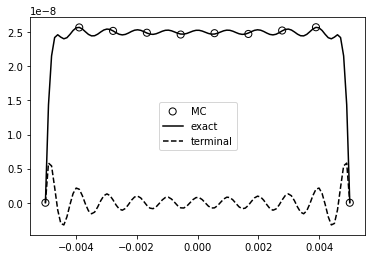

In [72]:
T = patches * 10
nb_sums = 10
exact_example = partial(exact_example_, nb_sums=nb_sums)

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun_full=p_example_full,
    phi_fun=partial(phi_example, nb_sums=nb_sums),
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model)

### T = 10 & nb_sums = 100

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


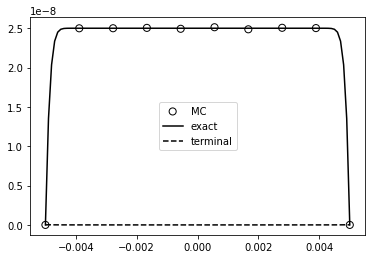

In [74]:
T = patches * 10
nb_sums = 100
exact_example = partial(exact_example_, nb_sums=nb_sums)

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun_full=p_example_full,
    phi_fun=partial(phi_example, nb_sums=nb_sums),
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model)

## T = 1000 & nb_sums=100

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


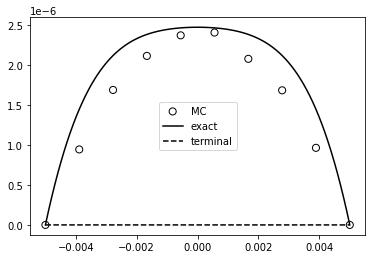

In [80]:
T = patches * 1000
nb_sums = 100
exact_example = partial(exact_example_, nb_sums=nb_sums)

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun_full=p_example_full,
    phi_fun=partial(phi_example, nb_sums=nb_sums),
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model)

## T = 100 & nb_sums=100

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


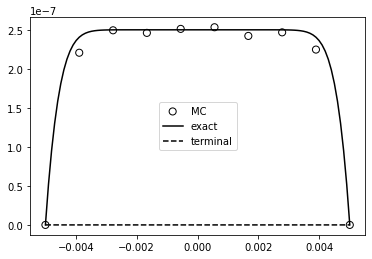

In [77]:
T = patches * 100
nb_sums = 100
exact_example = partial(exact_example_, nb_sums=nb_sums)

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun_full=p_example_full,
    phi_fun=partial(phi_example, nb_sums=nb_sums),
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model)

## T = 50 & nb_sums=100

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


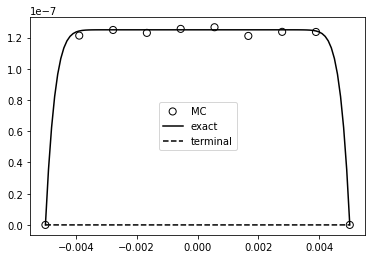

In [78]:
T = patches * 50
nb_sums = 100
exact_example = partial(exact_example_, nb_sums=nb_sums)

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun_full=p_example_full,
    phi_fun=partial(phi_example, nb_sums=nb_sums),
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model)

## T = 20 & nb_sums=100

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


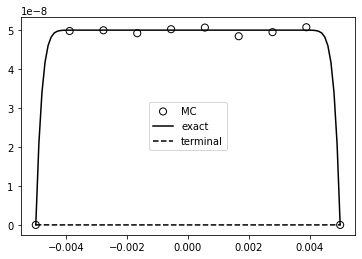

In [79]:
T = patches * 20
nb_sums = 100
exact_example = partial(exact_example_, nb_sums=nb_sums)

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun_full=p_example_full,
    phi_fun=partial(phi_example, nb_sums=nb_sums),
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model)